In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import copy
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Версии библиотек
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
NumPy: 2.3.4
Matplotlib: 3.10.7


## Установка Seed

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Аугментация данных

In [4]:
class TwoTransform:
    # Возвращает две разные версии одного изображеня
    def __init__(self, base_transform):
        self.base = base_transform
    def __call__(self, x):
        return self.base(x), self.base(x)

# Сдвиг, кадрирование, поворот и нормализация

# Для обучения BYOL
mnist_aug = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean и std пикселей на MNIST
])

# Для проверки линейной головы
linear_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Энкодер

In [5]:
class Encoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # 28x28
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # 14x14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten() # 1x1
        )
        self.fc = nn.Linear(128, rep_dim) # 1x1x128 -> 128
    def forward(self, x): return self.fc(self.net(x))

## Проекционная и предикторные головы

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x): return self.net(x)

## BYOL модель

In [7]:
class BYOL:
    def __init__(self, encoder, projector_dim, pred_hidden, tau):
        # Энкодер ученика
        self.student_encoder = encoder
        # Проекционная голова ученика
        self.student_projector = MLP(encoder.fc.out_features, pred_hidden, projector_dim)
        # Предикторная голова ученика (Без нее не сходится( )

        # Энкодер и голова учителя (одинаковое состояние)
        self.student_predictor = MLP(projector_dim, pred_hidden, projector_dim)
        self.teacher_encoder = copy.deepcopy(encoder)
        self.teacher_projector = copy.deepcopy(self.student_projector)
        # Замороска параметров учителя (обновление только через EMA)
        self._set_requires_grad(self.teacher_encoder, False)
        self._set_requires_grad(self.teacher_projector, False)
        self.tau = tau
    @staticmethod
    def _set_requires_grad(model, req):
        # Выключает градиенты для всех параметров модели
        for p in model.parameters(): p.requires_grad = req
    def to(self, device):
        self.student_encoder.to(device)
        self.student_projector.to(device)
        self.student_predictor.to(device)
        self.teacher_encoder.to(device)
        self.teacher_projector.to(device)
    def student_forward(self, x):
        y = self.student_encoder(x)
        z = self.student_projector(y)
        p = self.student_predictor(z)
        return y, z, p
    @torch.no_grad()
    def teacher_forward(self, x):
        y = self.teacher_encoder(x)
        z = self.teacher_projector(y)
        return y, z
    @torch.no_grad()
    def update_teacher(self):
        # Обновление параметров по EMA (theta_t ← τ · theta_t + (1 − τ) · theta_s)
        for t, s in zip(self.teacher_encoder.parameters(), self.student_encoder.parameters()):
            t.data = self.tau * t.data + (1 - self.tau) * s.data
        for t, s in zip(self.teacher_projector.parameters(), self.student_projector.parameters()):
            t.data = self.tau * t.data + (1 - self.tau) * s.data

def byol_loss(p, z_target):
    # Приближение двух аугментаций (косинусное сходство)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z_target, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1)

## Цикл обучения BYOL

In [8]:
def train_byol(byol, dataloader, optimizer, device, epochs, tau):
    byol.tau = tau
    byol.to(device)
    loss_list = []
    for epoch in range(1, epochs+1):
        byol.student_encoder.train()
        current_epoch = 0.0
        for (x1, x2), _ in tqdm(dataloader, desc=f"BYOL epoch {epoch}/{epochs}"):
            x1, x2 = x1.to(device), x2.to(device)
            _, z1, p1 = byol.student_forward(x1)
            _, z2, p2 = byol.student_forward(x2)
            with torch.no_grad():
                _, z1_t = byol.teacher_forward(x1)
                _, z2_t = byol.teacher_forward(x2)
            loss = (byol_loss(p1, z2_t).mean() + byol_loss(p2, z1_t).mean()) * 0.5
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            byol.update_teacher()
            current_epoch += loss.item() * x1.size(0)
        avg_loss = current_epoch / len(dataloader.dataset)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch}: BYOL loss = {avg_loss:.4f}")
    return loss_list

## Цикл обучения линейной головы

In [9]:
def train_linear(encoder, train_loader, test_loader, device, epochs, lr):
    encoder.eval()
    # Заморозка всех параметров энкодера
    for p in encoder.parameters(): p.requires_grad = False
    feat_dim = encoder.fc.out_features
    linear = nn.Linear(feat_dim, 10).to(device)
    opt = torch.optim.Adam(linear.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    acc_list = []
    for epoch in range(1, epochs+1):
        linear.train(); current = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad(): feats = encoder(x)
            logits = linear(feats)
            loss = criterion(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            current += loss.item() * x.size(0)
        avg = current / len(train_loader.dataset)
        acc = evaluate_encoder_linear(encoder, linear, test_loader, device)
        acc_list.append(acc)
        print(f"Linear eval epoch {epoch}: loss={avg:.4f}, acc={acc:.2f}%")
    return linear, acc_list

## Оценка точности линейной головы

In [10]:
def evaluate_encoder_linear(encoder, linear, test_loader, device):
    encoder.eval(); linear.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

## Загрузка MNIST и применение аугментаций

In [11]:
class MNISTTwoView(datasets.MNIST):
    def __init__(self, root, train, transform, download):
        super().__init__(root=root, train=train, transform=None, download=download)
        self.twotransform = transform
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        v1, v2 = self.twotransform(img)
        return (v1, v2), target

def make_dataloaders(batch_size_pretrain=256, batch_size_eval=256):
    # Для обучения BYOL
    pretrain_ds = MNISTTwoView(root='./data', train=True, transform=TwoTransform(mnist_aug), download=True)
    pretrain_loader = DataLoader(pretrain_ds, batch_size=batch_size_pretrain, shuffle=True, num_workers=0, drop_last=True)

    # Для обучения и тестирования линейной головы
    train_ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
    test_ds = datasets.MNIST(root='./data', train=False, transform=linear_aug, download=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size_eval, shuffle=True, num_workers=0) # Винда
    test_loader = DataLoader(test_ds, batch_size=batch_size_eval, shuffle=False, num_workers=0)

    return pretrain_loader, train_loader, test_loader

## Параметры

In [12]:
pretrain_epochs = 50
linear_epochs = 50
tau = 0.999

In [13]:
pretrain_loader, train_loader, test_loader = make_dataloaders()
encoder = Encoder(rep_dim=128)
byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

## Обучение BYOL

In [14]:
loss_list = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

BYOL epoch 1/50: 100%|██████████| 234/234 [01:16<00:00,  3.07it/s]


Epoch 1: BYOL loss = 0.5060


BYOL epoch 2/50: 100%|██████████| 234/234 [01:19<00:00,  2.96it/s]


Epoch 2: BYOL loss = 0.3063


BYOL epoch 3/50: 100%|██████████| 234/234 [01:15<00:00,  3.09it/s]


Epoch 3: BYOL loss = 0.2284


BYOL epoch 4/50: 100%|██████████| 234/234 [01:15<00:00,  3.11it/s]


Epoch 4: BYOL loss = 0.1833


BYOL epoch 5/50: 100%|██████████| 234/234 [01:16<00:00,  3.06it/s]


Epoch 5: BYOL loss = 0.1550


BYOL epoch 6/50: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 6: BYOL loss = 0.1359


BYOL epoch 7/50: 100%|██████████| 234/234 [01:25<00:00,  2.74it/s]


Epoch 7: BYOL loss = 0.1225


BYOL epoch 8/50: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 8: BYOL loss = 0.1125


BYOL epoch 9/50: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 9: BYOL loss = 0.1044


BYOL epoch 10/50: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 10: BYOL loss = 0.0991


BYOL epoch 11/50: 100%|██████████| 234/234 [01:21<00:00,  2.86it/s]


Epoch 11: BYOL loss = 0.0951


BYOL epoch 12/50: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 12: BYOL loss = 0.0911


BYOL epoch 13/50: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 13: BYOL loss = 0.0879


BYOL epoch 14/50: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 14: BYOL loss = 0.0851


BYOL epoch 15/50: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 15: BYOL loss = 0.0825


BYOL epoch 16/50: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 16: BYOL loss = 0.0812


BYOL epoch 17/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 17: BYOL loss = 0.0792


BYOL epoch 18/50: 100%|██████████| 234/234 [01:21<00:00,  2.86it/s]


Epoch 18: BYOL loss = 0.0778


BYOL epoch 19/50: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 19: BYOL loss = 0.0770


BYOL epoch 20/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 20: BYOL loss = 0.0756


BYOL epoch 21/50: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 21: BYOL loss = 0.0748


BYOL epoch 22/50: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 22: BYOL loss = 0.0739


BYOL epoch 23/50: 100%|██████████| 234/234 [01:21<00:00,  2.86it/s]


Epoch 23: BYOL loss = 0.0736


BYOL epoch 24/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 24: BYOL loss = 0.0727


BYOL epoch 25/50: 100%|██████████| 234/234 [01:22<00:00,  2.85it/s]


Epoch 25: BYOL loss = 0.0723


BYOL epoch 26/50: 100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch 26: BYOL loss = 0.0720


BYOL epoch 27/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 27: BYOL loss = 0.0710


BYOL epoch 28/50: 100%|██████████| 234/234 [01:22<00:00,  2.84it/s]


Epoch 28: BYOL loss = 0.0711


BYOL epoch 29/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 29: BYOL loss = 0.0702


BYOL epoch 30/50: 100%|██████████| 234/234 [01:22<00:00,  2.82it/s]


Epoch 30: BYOL loss = 0.0699


BYOL epoch 31/50: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 31: BYOL loss = 0.0699


BYOL epoch 32/50: 100%|██████████| 234/234 [01:17<00:00,  3.00it/s]


Epoch 32: BYOL loss = 0.0695


BYOL epoch 33/50: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 33: BYOL loss = 0.0696


BYOL epoch 34/50: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 34: BYOL loss = 0.0686


BYOL epoch 35/50: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s]


Epoch 35: BYOL loss = 0.0687


BYOL epoch 36/50: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch 36: BYOL loss = 0.0686


BYOL epoch 37/50: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s]


Epoch 37: BYOL loss = 0.0683


BYOL epoch 38/50: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 38: BYOL loss = 0.0682


BYOL epoch 39/50: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 39: BYOL loss = 0.0677


BYOL epoch 40/50: 100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Epoch 40: BYOL loss = 0.0674


BYOL epoch 41/50: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 41: BYOL loss = 0.0672


BYOL epoch 42/50: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 42: BYOL loss = 0.0672


BYOL epoch 43/50: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 43: BYOL loss = 0.0669


BYOL epoch 44/50: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s]


Epoch 44: BYOL loss = 0.0666


BYOL epoch 45/50: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s]


Epoch 45: BYOL loss = 0.0666


BYOL epoch 46/50: 100%|██████████| 234/234 [01:21<00:00,  2.88it/s]


Epoch 46: BYOL loss = 0.0664


BYOL epoch 47/50: 100%|██████████| 234/234 [01:20<00:00,  2.92it/s]


Epoch 47: BYOL loss = 0.0665


BYOL epoch 48/50: 100%|██████████| 234/234 [01:20<00:00,  2.91it/s]


Epoch 48: BYOL loss = 0.0660


BYOL epoch 49/50: 100%|██████████| 234/234 [01:21<00:00,  2.87it/s]


Epoch 49: BYOL loss = 0.0664


BYOL epoch 50/50: 100%|██████████| 234/234 [01:21<00:00,  2.86it/s]

Epoch 50: BYOL loss = 0.0659


## Обучение линейной головы

In [15]:
frozen_encoder = byol.student_encoder
_, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

Linear eval epoch 1: loss=1.8049, acc=91.63%
Linear eval epoch 2: loss=1.1171, acc=94.21%
Linear eval epoch 3: loss=0.7588, acc=94.76%
Linear eval epoch 4: loss=0.5658, acc=95.17%
Linear eval epoch 5: loss=0.4515, acc=95.38%
Linear eval epoch 6: loss=0.3774, acc=95.82%
Linear eval epoch 7: loss=0.3257, acc=96.02%
Linear eval epoch 8: loss=0.2878, acc=96.15%
Linear eval epoch 9: loss=0.2588, acc=96.35%
Linear eval epoch 10: loss=0.2358, acc=96.48%
Linear eval epoch 11: loss=0.2172, acc=96.61%
Linear eval epoch 12: loss=0.2019, acc=96.70%
Linear eval epoch 13: loss=0.1890, acc=96.77%
Linear eval epoch 14: loss=0.1780, acc=96.89%
Linear eval epoch 15: loss=0.1685, acc=97.06%
Linear eval epoch 16: loss=0.1602, acc=97.08%
Linear eval epoch 17: loss=0.1530, acc=97.19%
Linear eval epoch 18: loss=0.1467, acc=97.26%
Linear eval epoch 19: loss=0.1409, acc=97.39%
Linear eval epoch 20: loss=0.1359, acc=97.42%
Linear eval epoch 21: loss=0.1313, acc=97.41%
Linear eval epoch 22: loss=0.1272, acc=97.5

## Графики процесса обучения

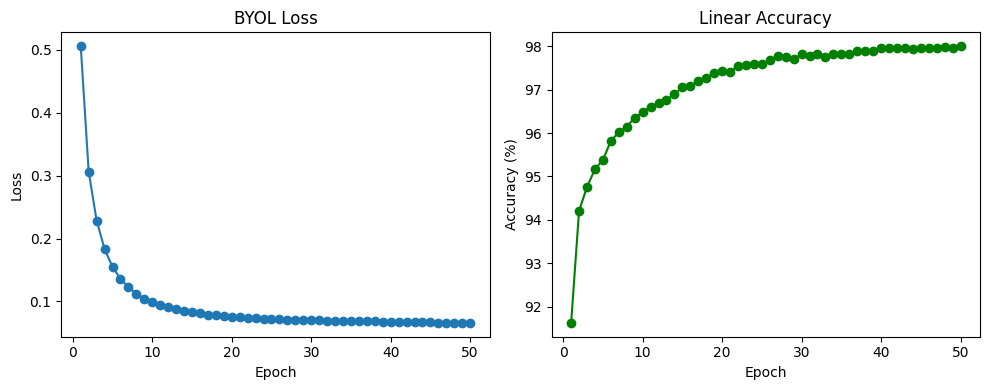

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(loss_list)+1), loss_list, marker='o')
plt.title("BYOL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(acc_list)+1), acc_list, marker='o', color='green')
plt.title("Linear Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

## TSNE График

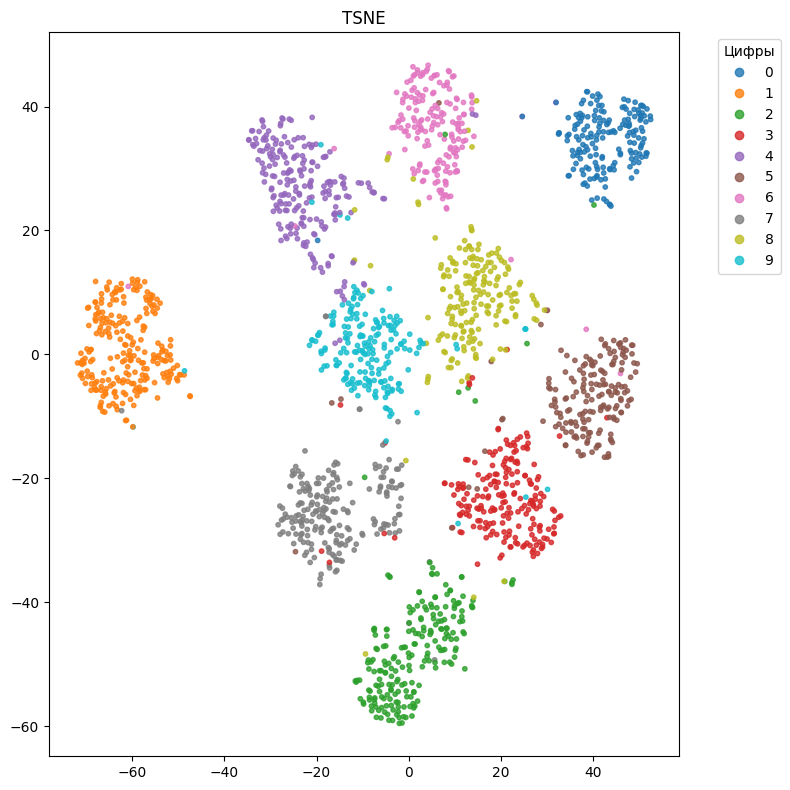

In [18]:
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(encoder, dataloader, device, n_samples=2000):
    encoder.eval()
    feats_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            feats_list.append(feats.cpu())
            labels_list.append(y.cpu())
            if len(torch.cat(labels_list)) >= n_samples:
                break

    feats = torch.cat(feats_list)[:n_samples]
    labels = torch.cat(labels_list)[:n_samples]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    emb_2d = tsne.fit_transform(feats.numpy())

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Цифры", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("TSNE")
    plt.tight_layout()
    plt.show()

visualize_embeddings_tsne(frozen_encoder, test_loader, device)

## Матрица ошибок

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
def plot_confusion_matrix(encoder, linear, test_loader, device):
    encoder.eval()
    linear.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Матрица ошибок - BYOL")
    plt.show()


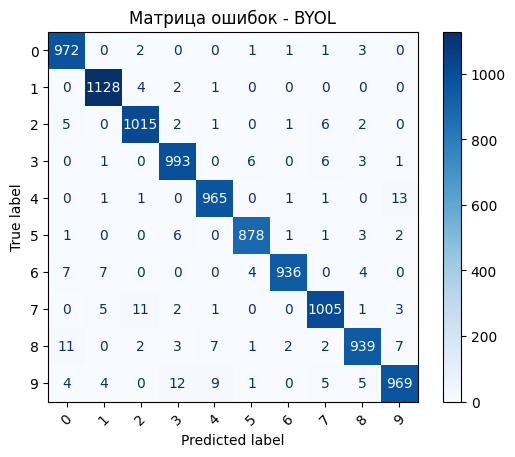

In [21]:
plot_confusion_matrix(frozen_encoder, _, test_loader, device)